In [1]:
# from models.DynaGAN_ffhq import DynaGAN
from models.DynaGAN import SG2Generator

In [2]:
import numpy as np
import torch
import torchvision
import os

toPIL = torchvision.transforms.ToPILImage()


In [3]:
from torchvision import transforms

In [4]:
from PIL import Image

In [5]:
def tensor2im(var):
    var = var.cpu().detach().transpose(0, 2).transpose(0, 1).numpy()
    var = ((var + 1) / 2)
    var[var < 0] = 0
    var[var > 1] = 1
    var = var * 255
    return Image.fromarray(var.astype('uint8'))

In [6]:
class DynaGANOptions:
    device = "cuda"
    frozen_gen_ckpt = "/kuacc/users/aanees20/DynaGAN/pretrained_models/ffhq.pt"
    size = 1024
    train_gen_ckpt = "/kuacc/users/aanees20/DynaGAN/output_disc_mlp/checkpoint/final.pt"
    c_dim = 9
    no_scaling = False
    no_residual = False
    phase = None
    e4e_checkpoint_path = "/kuacc/users/aanees20/DynaGAN/pretrained_models/e4e_ffhq_encode.pt"
    lambda_id = 0
    clip_models = ["ViT-B/32", "ViT-B/16"]
    clip_model_weights = [1.0, 1.0]
    lambda_direction = 1.0
    lambda_patch = 0.0
    lambda_global = 0.0
    lambda_manifold = 0.0
    lambda_texture = 0.0
    lambda_contrast = 0
    batch = 4
    truncation = 0.7

In [7]:
args = DynaGANOptions

In [8]:
image_path = "/datasets/ffhq/images1024x1024/"

In [9]:
print('Load finetuned generator')

target_ckpt = torch.load(args.train_gen_ckpt, map_location=args.device)

Load finetuned generator


In [10]:
# style_latent = target_ckpt["style_latent"]
latent_avg = target_ckpt["latent_avg"].type(torch.FloatTensor).to(args.device)
# c_dim = target_ckpt['c_dim']
is_dynagan = target_ckpt['is_dynagan']

In [11]:
generator = SG2Generator(args.train_gen_ckpt, img_size=args.size, c_dim=9, no_scaling=args.no_scaling, no_residual=args.no_residual, is_dynagan=is_dynagan).to(args.device)
generator.eval()
# conv1.conv.hypernet.out_channel_estimator.weight
n_latents =  generator.generator.n_latent

In [21]:
latent_mean=latent_avg.unsqueeze(0).repeat(18,1).unsqueeze(0).repeat(4,1,1)

In [101]:
latent_mean.shape

torch.Size([4, 18, 512])

In [12]:
names = [os.path.join(image_path, path) for path in os.listdir(image_path)]

In [8]:
names[0]

'/datasets/ffhq/images1024x1024/00000.png'

In [13]:
img_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [69]:
# img_tensor = img_transforms(img_cond).unsqueeze(0)

In [70]:
# img_tensor.shape

torch.Size([1, 3, 1024, 1024])

In [14]:
from torch import nn

In [15]:
upsample = nn.Upsample(scale_factor=7)
avg_pool = nn.AvgPool2d(kernel_size=1024 // 32)

In [12]:
# import json

In [17]:
# simi = []
# max_sim = {"sim": 0, "path": None}
# for name in names:
#     img = Image.open(name)
#     img_tensor = img_transforms(img).unsqueeze(0)
# #     img_embed = clip_model.encode_image(img_preprocess).to(torch.float32).unsqueeze(0)
# #     txt_embed = txt_embed_original
#     image = avg_pool(upsample(img_tensor))
#     similarity = 1 - clip_model(image.cuda(),text_original)[0] / 100
#     simi.append(similarity.item())
#     if max_sim["sim"] < similarity:
#         max_sim["sim"] = similarity.item()
#         max_sim["path"] = name
#         with open("clip_sim.json", "w") as write_file:
#             json.dump(max_sim, write_file, indent=4)
        

KeyboardInterrupt: 

In [16]:
import clip

In [17]:
clip_model, clip_preprocess = clip.load("ViT-B/16", device = args.device)

In [18]:
batch_size = 4

In [19]:
sample_z = torch.randn(args.batch, 512, device=args.device)

In [55]:
w_styles = generator.style([sample_z])[0]
# w_styles = latent_mean

output_latents = args.truncation * (w_styles - latent_avg) + latent_avg
output_latents = output_latents.unsqueeze(1).repeat(1, n_latents, 1)

In [52]:
# w_styles_avg = generator.style([sample_z*0])[0]


In [56]:
w = [output_latents]

In [83]:
txt = "This person has grey hair"

text_original = clip.tokenize(txt).to(args.device)

with torch.no_grad():
    txt_embed_original = clip_model.encode_text(text_original)
txt_embed_original = txt_embed_original.to(args.device).float()

txt_embed_original = txt_embed_original.repeat(batch_size,1)



In [120]:
# name = "/kuacc/users/aanees20/DynaGAN/target_data/raw_data2/231010-00.png"
name = "/kuacc/users/aanees20/DynaGAN/target_data/raw_data/11375-00.png"
img_cond = Image.open(name)

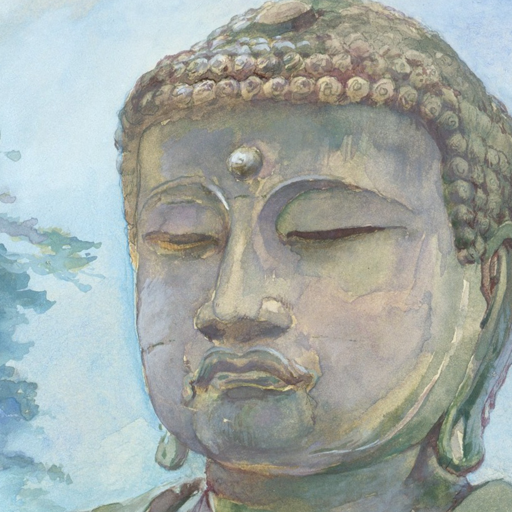

In [121]:
img_cond.resize((512,512))

In [35]:
from options.face_embed_options import II2S_s_opts
from models.II2S import II2S

In [37]:
style_img_dir = name
ii2s = II2S(II2S_s_opts)
# start_inversion_time = time.time()
latents = ii2s.invert_images(image_path=style_img_dir, output_dir=None,
                            return_latents=True, align_input=False, save_output=False)[0]
# end_inversion_time = time.time()
# print(f"inversion time: {end_inversion_time - start_inversion_time}s")
latents = latents.detach().clone().cpu()
# np.save(os.path.join(self.args.output_dir, "inverted_latents.npy"), latents.cpu().numpy())
ii2s = ii2s.cpu()
# del ii2s

Loading StyleGAN2 from checkpoint: pretrained_models/ffhq.pt
Setting up Perceptual loss...
Loading model from: /scratch/users/aanees20/DynaGAN/losses/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done
Number of images: 1


  0%|          | 0/1 [00:00<?, ?it/s]

Embedding:   0%|          | 0/1000 [00:00<?, ?it/s]

In [39]:
generator.ZP_target_latent = latents

In [42]:
w[0][:, 7:, :] = latents[:, 7:, :].cuda()

In [73]:
# img_cond = Image.open(names[19])

In [122]:
img_preprocess = clip_preprocess(img_cond).unsqueeze(0).cuda()

In [123]:
img_embed = clip_model.encode_image(img_preprocess).to(torch.float32)
img_embed = img_embed.repeat(batch_size,1)

In [124]:
# domain_label = txt_embed_original
domain_label = img_embed

In [125]:
outputs2 = generator(w, input_is_latent=True, randomize_noise=False, domain_labels=[domain_label],domain_is_latents=True)[0]

In [30]:
outputs_fixed = generator([output_latents], input_is_latent=True, randomize_noise=False)[0]

In [31]:
face_pool = torch.nn.AdaptiveAvgPool2d((512, 512))

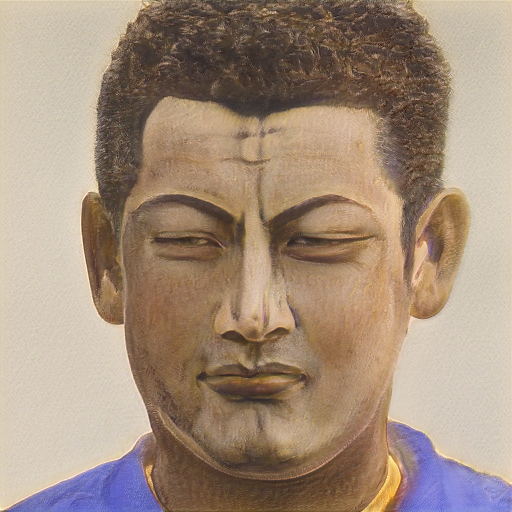

In [126]:
tensor2im(face_pool(outputs2[2]))

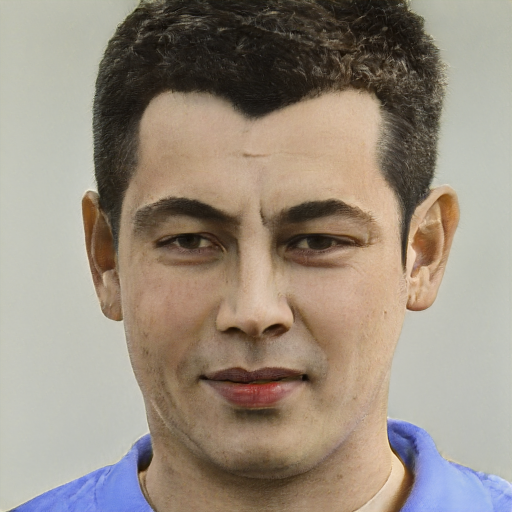

In [105]:
tensor2im(face_pool(outputs2[2]))

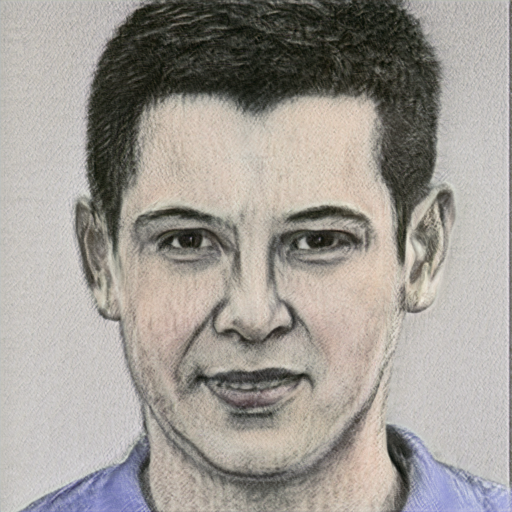

In [78]:
tensor2im(face_pool(outputs2[2]))

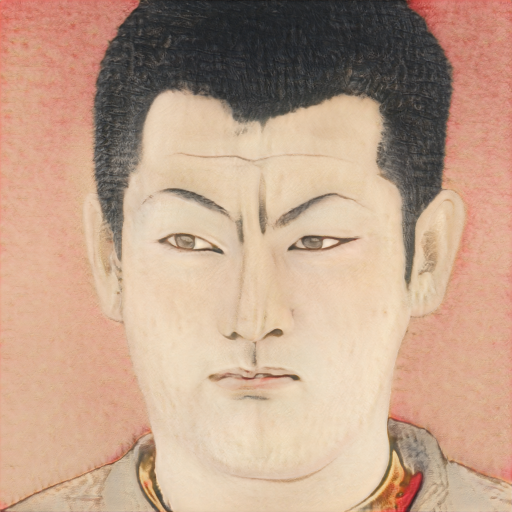

In [44]:
tensor2im(face_pool(outputs2[2]))

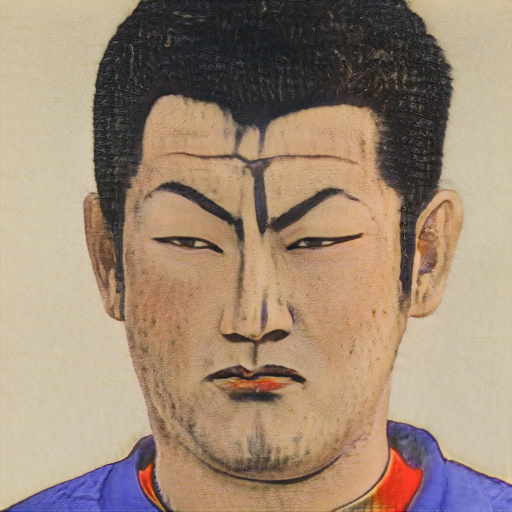

In [66]:
tensor2im(face_pool(outputs2[2]))

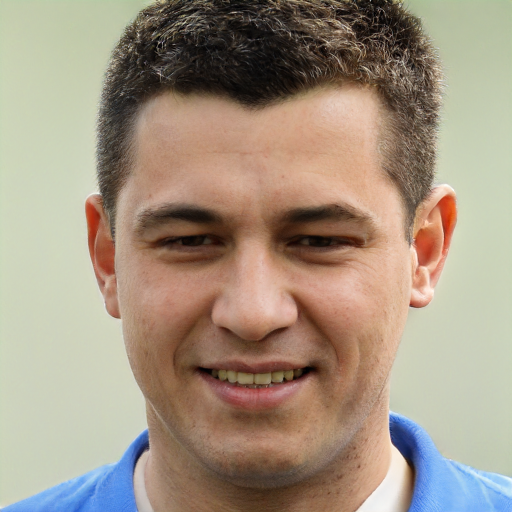

In [33]:
tensor2im(face_pool(outputs_fixed[2]))